## Neural Network

构建一个神经网络来认识数字 MNIST。 


In [1]:
### 初始化加载库
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### 1. 加载数据 
首先看一下数据长什么样子。这样最直观。


In [2]:
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data ():
    """
        返回: (train_data, val_date, test_data)
    """
    f = gzip.open('./mnist.pkl.gz', 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='bytes')
    f.close()
    return (train_data, val_data, test_data)

def load_data_wrapper ():
    """
        由于进行数字认识是一个多分类(multi-classifier)问题，数字 0~9，10 个分类
        所以可以对训练数据进行下预处理:
             1. 使样本的特征的 shape 从 (784,) 变成 (784, 1)
             2. 使分类标签变量变成 (10, 1) , 仅针对训练数据。
    """
    train_data, val_data, test_data = load_data()
    train_X = [x.reshape(784, 1) for x in train_data[0]]
    train_y = [vectorize(y) for y in train_data[1]]
    
    val_X = [x.reshape(784, 1) for x in val_data[0]]
    test_X = [x.reshape(784, 1) for x in test_data[0]]
    
    return (
        list(zip(train_X, train_y)), 
        list(zip(val_X, val_data[1])),
        list(zip(test_X, test_data[1]))
    )

def vectorize(y):
    '''
        返回一个 shape 为 (10, 1) 的 column vector.
        - y: 需要置 1 的位置。
    '''
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e
    
def get_images (data):
    images, _ = data
    return [img.reshape(28, -1) for img in images]

def plot_images6 (images):
    "Random plot six MNIST images separately"
    ilist = np.random.permutation(range(len(images)))
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[ilist[j]], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [3]:
train_data, val_data, test_data = load_data()

In [4]:
def printDataInfo(data, name):
    print("\n", name, type(data), len(data))
    X, y = data
    print('X:', type(X), X.shape, X[0].shape)
    print('y:', type(y), y.shape)
    
printDataInfo(train_data, 'train_data')
printDataInfo(val_data, 'val_data')
printDataInfo(test_data, 'test_data')


 train_data <class 'tuple'> 2
X: <class 'numpy.ndarray'> (50000, 784) (784,)
y: <class 'numpy.ndarray'> (50000,)

 val_data <class 'tuple'> 2
X: <class 'numpy.ndarray'> (10000, 784) (784,)
y: <class 'numpy.ndarray'> (10000,)

 test_data <class 'tuple'> 2
X: <class 'numpy.ndarray'> (10000, 784) (784,)
y: <class 'numpy.ndarray'> (10000,)


从上面可以看出，我们的数据集共有 `70,000` 个样本，每一个样本是 `28 * 28 = 784` 个像素所组成的图片。

我们将 `70,000` 个样本分成：

    - 训练数据, training data: 50,000
    - 验证数据, validation data: 10,000
    - 测试数据, test data: 10,000

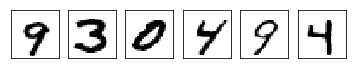

In [5]:
images = get_images(train_data)
plot_images6(images)

### 模型构建

In [8]:
"""
实现随机梯度下降版的 NN
"""
import random
import numpy as np

class Network(object):
    
    def __init__(self, sizes):
        '''
            sizes 是 NN 每层的单元数。
            Ex: sizes = [2, 3, 1]
            则说明，NN 共有 3 层，即一个输入层，一个隐藏层和一个输出层，
            每层的单元个数，分别是 2, 3, 1.
            我们为每层的参数进行初始化。
            注意：输入层是没有偏置 bias 参数的。
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(nLayer, 1) for nLayer in sizes[1:]]
        self.weights = [np.random.randn(nLayer, nPreLayer)
                        for nLayer, nPreLayer in zip(sizes[1:], sizes[:-1])]
        
    def FP(self, a):
        '''
            使用 Feed Forward 将 a 作为输入参数，返回输出层。
        '''
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def StochasticGD(self, train_data, epochs, mini_batch_size, alpha, test_data = None):
        '''
            使用 mini-batch stochastic gradient descent 来训练模型。
        '''
        
        if test_data: n_test = len(test_data)
        n = len(train_data)
        for i in range(epochs):
            random.shuffle(train_data)
            mini_batches = [train_data[k: k + mini_batch_size] 
                            for k in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, alpha)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    i, self.evaluate(test_data), n_test
                ))
            else:
                print("Epock {0} complete".format(i))
    
    def update_mini_batch(self, mini_batch, alpha):
        '''
            使用 BP 来更新参数。
        '''
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # 对每个样本每层的 𝛁b, 𝛁w 进行累加
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.BP(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        am = alpha * (1 / len(mini_batch))
        self.weights = [w - am * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - am * nb for b, nb in zip(self.biases, nabla_b)]
        
    def BP(self, x, y):
        '''
            实现 BP。返回一个元组 `(Nabla_b, Nabla_w)` 即 `(𝛁b, 𝛁w)`.
            𝛁b, 𝛁w 和每层的 b, w 的维度是一样的。
        '''
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # FP
        a = x
        cache_a = [x] # list to store all the activations for all layer
        cache_z = [] # list to store all the z vectors for all layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            a = sigmoid(z)
            cache_z.append(z)
            cache_a.append(a)
        
        # Backward pass 计算输出层的 delta
        delta = self.cost_derivative(cache_a[-1], y) * sigmoid_prime(cache_z[-1])
        # 计算输出层的 𝛁b, 𝛁w
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, cache_a[-2].T)
        
        # 计算隐藏层的 𝛁b, 𝛁w
        for l in range(2, self.num_layers):
            z = cache_z[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, cache_a[-l - 1].T)
        
        return (nabla_b, nabla_w)
    
    def cost_derivative(self, output_a, y):
        """
            返回最终输出层的误差
        """
        return (output_a - y)
    
    def evaluate(self, test_data):
        """
            返回测试样本正确的分类数。
        """
        test_results = [(np.argmax(self.FP(x)), y) 
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    

### Miscellaneous functions
def sigmoid(z):
    ''' The sigmoid function '''
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    ''' Derivative of the sigmoid function '''
    return sigmoid(z) * (1 - sigmoid(z))
        

### Delta 与 Nabla
Delta 𝚫 和 Nabla 𝛁 一般都可表示微分符号，一般都称为 Laplace operator。

### 测试模型

In [9]:
train_data, val_data, test_data = load_data_wrapper()
print(type(train_data), type(val_data), type(test_data))
net = Network([784, 30, 10])
net.StochasticGD(train_data, 30, 10, 3.0, test_data = test_data)

<class 'list'> <class 'list'> <class 'list'>
Epoch 0: 9078 / 10000
Epoch 1: 9229 / 10000
Epoch 2: 9326 / 10000
Epoch 3: 9345 / 10000
Epoch 4: 9378 / 10000
Epoch 5: 9409 / 10000
Epoch 6: 9444 / 10000
Epoch 7: 9431 / 10000
Epoch 8: 9450 / 10000
Epoch 9: 9473 / 10000
Epoch 10: 9443 / 10000
Epoch 11: 9464 / 10000
Epoch 12: 9483 / 10000
Epoch 13: 9492 / 10000
Epoch 14: 9486 / 10000
Epoch 15: 9450 / 10000
Epoch 16: 9466 / 10000
Epoch 17: 9489 / 10000
Epoch 18: 9482 / 10000
Epoch 19: 9504 / 10000
Epoch 20: 9488 / 10000
Epoch 21: 9516 / 10000
Epoch 22: 9497 / 10000
Epoch 23: 9460 / 10000
Epoch 24: 9504 / 10000
Epoch 25: 9515 / 10000
Epoch 26: 9507 / 10000
Epoch 27: 9507 / 10000
Epoch 28: 9516 / 10000
Epoch 29: 9513 / 10000


In [21]:
sizes = [3, 4, 4, 4, 4, 2]
nn = Network(sizes)
# 测试初始化
print('Test for constructor')
for i, (w, b) in enumerate(zip(nn.weights, nn.biases)):
    print('Layer {0}, weights dims: {1}, biases dims: {2}'.format(i, w.shape, b.shape))

# 测试样本
print('Test for FP')
X = np.random.randn(3, 1)
print(X.shape)
nn.FP(X)

Test for constructor
Layer 0, weights dims: (4, 3), biases dims: (4, 1)
Layer 1, weights dims: (4, 4), biases dims: (4, 1)
Layer 2, weights dims: (4, 4), biases dims: (4, 1)
Layer 3, weights dims: (4, 4), biases dims: (4, 1)
Layer 4, weights dims: (2, 4), biases dims: (2, 1)
Test for FP
(3, 1)


array([[0.55889952],
       [0.71759698]])